In [1]:
import torch
import torch.nn as nn
from utils import train
from bin_packing_dataset import BinPackingDataset
from bin_packing_model import BinPackingLSTMModel
from torch.utils.data import random_split

In [2]:
# Fijamos la semilla para que los resultados sean reproducibles
SEED = 23

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# Algunas constantes

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS

NUM_WORKERS = 0 # max(os.cpu_count() - 1, 1)  # número de workers para cargar los datos


print(f"Device: {DEVICE}")
print(f"Num Workers: {NUM_WORKERS}")

Device: mps
Num Workers: 0


### Exploración del Dataset

In [4]:
#Creacion del dataset de entrenamiento, validacion y test

full_dataset = BinPackingDataset('data')
print('Full dataset size:', len(full_dataset))
container_tensor, boxes_tensor = full_dataset[0]
print('Container:', container_tensor)
print('Boxes:', boxes_tensor)

train_dataset, val_dataset = random_split(full_dataset, [int(0.8*len(full_dataset)), int(0.20*len(full_dataset))])
print('Train dataset size:', len(train_dataset))
print('Val dataset size:', len(val_dataset))

Full dataset size: 81000
Container: tensor([14., 11.])
Boxes: tensor([[ 8.,  7.],
        [12.,  2.],
        [ 1.,  2.],
        [ 2.,  7.],
        [ 4.,  8.],
        [ 0.,  0.]])
Train dataset size: 64800
Val dataset size: 16200


In [5]:
# Collate para manejar secuencias de diferentes longitudes
import torch.nn.utils.rnn as rnn_utils

def custom_collate_fn_with_padding(batch):
    """
    Collate function que mantiene la estructura de contenedor y agrega padding a las secuencias de cajas.
    
    Args:
        batch (list): Lista de tuplas (contenedor, cajas).
        
    Returns:
        tuple: (contenedores, cajas_padded, longitudes) donde:
            - contenedores: Tensor de tamaño (batch_size, 2).
            - cajas_padded: Tensor de tamaño (batch_size, max_len, 2) con padding.
            - longitudes: Tensor de tamaños originales de las secuencias de cajas.
    """
    containers = torch.stack([item[0] for item in batch])  # Contenedores como tensor
    boxes = [item[1] for item in batch]  # Lista de cajas
    
    # Padding de las secuencias de cajas (rellenar con ceros hasta la longitud máxima en el batch)
    boxes_padded = rnn_utils.pad_sequence(boxes, batch_first=True)
    
    # Longitudes originales de cada secuencia de cajas
    lengths = torch.tensor([len(b) for b in boxes])
    
    return containers, boxes_padded



BATCH_SIZE = 40000
mock_loader = torch.utils.data.DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn_with_padding)

container, target_seq = next(iter(mock_loader))
print('Tamaño del primer contenedor:', container.shape)
print('Tamaño de las cajas del primer contenedor:', target_seq.shape)


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn_with_padding)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn_with_padding)

Tamaño del primer contenedor: torch.Size([40000, 2])
Tamaño de las cajas del primer contenedor: torch.Size([40000, 11, 2])


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

class AutoRegressiveBinPackingModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, max_dim, n_layers, dropout=0.1):
        super(AutoRegressiveBinPackingModel, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.max_dim = max_dim
        
        # Embedding para entrada (contenedor y cajas)
        self.embedding = nn.Linear(input_dim, hidden_dim)
        
        # LSTM para modelar secuencias
        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout
        )
        
        # Proyección para obtener logits de distribuciones de width y height
        self.fc_width = nn.Linear(hidden_dim, max_dim + 1)  # +1 para incluir el token EOS
        self.fc_height = nn.Linear(hidden_dim, max_dim + 1)
    
    def forward(self, container, target_seq=None, seq_len=100, teacher_forcing_ratio=0.5):
        """
        Args:
            container: Tensor con las dimensiones del contenedor (batch_size, input_dim).
            target_seq: Secuencia objetivo durante entrenamiento (batch_size, seq_len, input_dim).
            seq_len: Longitud máxima de secuencia durante generación.
            teacher_forcing_ratio: Probabilidad de usar teacher forcing (0.0 a 1.0).
        
        Returns:
            Logits para distribuciones de width y height.
        """
        container_emb = self.embedding(container).unsqueeze(1)  # (batch_size, 1, hidden_dim)
        
        # Para almacenar las salidas durante la generación
        outputs_width = []
        outputs_height = []
        
        # Estado inicial
        generated_seq = container_emb
        hidden = None
        
        for t in range(seq_len):
            output, hidden = self.lstm(generated_seq, hidden)  # (batch_size, 1, hidden_dim)
            
            # Logits para width y height
            logits_width = self.fc_width(output[:, -1, :])  # (batch_size, max_dim+1)
            logits_height = self.fc_height(output[:, -1, :])  # (batch_size, max_dim+1)
            outputs_width.append(logits_width)
            outputs_height.append(logits_height)
            
            if target_seq is not None and torch.rand(1).item() < teacher_forcing_ratio:
                # Usar la secuencia objetivo (teacher forcing)
                next_box = target_seq[:, t, :]  # (batch_size, 2)
            else:
                # Sampleo de la predicción
                prob_width = F.softmax(logits_width, dim=-1)  # (batch_size, max_dim+1)
                prob_height = F.softmax(logits_height, dim=-1)  # (batch_size, max_dim+1)
                next_width = torch.multinomial(prob_width, num_samples=1)  # (batch_size, 1)
                next_height = torch.multinomial(prob_height, num_samples=1)  # (batch_size, 1)
                next_box = torch.cat([next_width, next_height], dim=1)  # (batch_size, 2)
            
            # Preparar la entrada para el siguiente paso
            next_box_emb = self.embedding(next_box.float())  # Convertir a embedding
            # Concatenamos la secuencia generada con la nueva caja
            generated_seq = torch.cat([generated_seq, next_box_emb.unsqueeze(1)], dim=1)
        
        # Apilar las salidas
        logits_width = torch.stack(outputs_width, dim=1)  # (batch_size, seq_len, max_dim+1)
        logits_height = torch.stack(outputs_height, dim=1)  # (batch_size, seq_len, max_dim+1)
        return logits_width, logits_height


In [7]:
#Definimos nuestra propia Loss Function para tener la misma firma en el forward
class BaseBinPackingProblemLoss(nn.Module):
    def __init__(self, max_dim, device):
        super(BaseBinPackingProblemLoss, self).__init__()
        self.max_dim = max_dim
        self.axis_criterion = nn.CrossEntropyLoss()
        self.to(device)
    
    def forward(self, container, logits_width, logits_height, target_seq):
        """
        Args:
            container: Tensor con las dimensiones del contenedor (batch_size, 2).
            logits_width: Logits de la distribución de width (batch_size, seq_len, max_dim+1).
            logits_height: Logits de la distribución de height (batch_size, seq_len, max_dim+1).
            target_seq: Secuencia objetivo (batch_size, seq_len, 2).
        
        Returns:
            Loss.
        """

        # Cross-entropy loss
        target_width = target_seq[:, :, 0].long()  # (batch_size, seq_len)
        target_height = target_seq[:, :, 1].long()  # (batch_size, seq_len)
        loss_width = self.axis_criterion(logits_width.view(-1, self.max_dim+1), target_width.view(-1))
        loss_height = self.axis_criterion(logits_height.view(-1, self.max_dim+1), target_height.view(-1))
        return loss_width + loss_height

In [19]:
# Configuración
from utils import EarlyStopping


MAX_DIM = 20

def evaluate(model, criterion,  data_loader, device, teacher_forcing_ratio):
    """
    Evalúa el modelo en los datos proporcionados y calcula la pérdida promedio.

    Args:
        model (torch.nn.Module): El modelo que se va a evaluar.
        criterion (torch.nn.Module): La función de pérdida que se utilizará para calcular la pérdida.
        data_loader (torch.utils.data.DataLoader): DataLoader que proporciona los datos de evaluación.
        device (str): El dispositivo donde se ejecutará el cálculo.
        teacher_forcing_ratio (float): Prop

    Returns:
        float: La pérdida promedio en el conjunto de datos de evaluación.

    """
    model.eval()  # ponemos el modelo en modo de evaluacion
    total_loss = 0  # acumulador de la perdida
    with torch.no_grad():  # deshabilitamos el calculo de gradientes
        for container, target_seq in data_loader:  # iteramos sobre el dataloader
            container = container.to(device)  # movemos los datos al dispositivo
            target_seq = target_seq.to(device)  # movemos los datos al dispositivo
            logits_width, logits_height = model(
                container, 
                target_seq=target_seq, 
                seq_len=target_seq.size(1), 
                teacher_forcing_ratio=teacher_forcing_ratio
            )
            loss = criterion(container, logits_width, logits_height, target_seq).item()
            total_loss += loss  # acumulamos la perdida
    return total_loss / len(data_loader)  # retornamos la perdida promedio
def train(
        model,
        criterion,
        optimizer,
        epochs = 500,
        patience=7,
        teacher_forcing_initial_ratio = 0.5,
        teacher_forcing_decay = 0.95,
        device = DEVICE
        ):
    """
    Entrena un modelo de PyTorch.
    Args:
        model (torch.nn.Module): El modelo que se va a entrenar.
        patience (int): Número de épocas sin mejora antes de detener el entrenamiento.
        teacher_forcing_initial_ratio (float): Proporción de teacher forcing al comenzar el entrenamiento.
    """
    early_stopping = EarlyStopping(patience=patience)
    teacher_forcing_ratio = teacher_forcing_initial_ratio
    for epoch in range(epochs):
        model.train()
        teacher_forcing_ratio *= teacher_forcing_decay  # Reducimos el ratio por cada época
        train_loss = 0
        
        for container, target_seq in train_dataloader:
            container = container.to(device)
            target_seq = target_seq.to(device)
            
            optimizer.zero_grad()
            logits_width, logits_height = model(
                container, 
                target_seq=target_seq, 
                seq_len=target_seq.size(1), 
                teacher_forcing_ratio=teacher_forcing_ratio
            )
            loss = criterion(container, logits_width, logits_height, target_seq)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_dataloader)}")
        val_loss = evaluate(model, criterion, val_dataloader, device, teacher_forcing_ratio)
        print(f"Epoch {epoch+1}/{epochs}, Val Loss: {val_loss}")
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Detener entrenamiento en la época {epoch}, la mejor pérdida fue {early_stopping.best_score:.5f}")
            break



In [ ]:
# Datos de entrenamiento
criterion = BaseBinPackingProblemLoss(MAX_DIM, DEVICE)
input_dim = 2
hidden_dim = 30
n_layers = 1
dropout = 0

# Modelo
model = AutoRegressiveBinPackingModel(input_dim, hidden_dim, MAX_DIM, n_layers, dropout)
model.to(DEVICE)
# Hiperparámetros
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train(model,criterion, optimizer,epochs=2000)

In [9]:
from models import Box


def generate_sequence(model, container, max_seq_len=10):
    """
    Genera una secuencia de cajas para un contenedor dado utilizando un modelo entrenado.
    
    Args:
        model: El modelo entrenado.
        container: Tensor con las dimensiones del contenedor (batch_size, input_dim).
        max_seq_len: Longitud máxima de la secuencia que se desea generar.
        
    Returns:
        Secuencia generada de dimensiones (seq_len, 2), con el formato de (width, height).
    """
    model.eval()  # Poner el modelo en modo evaluación
    
    # Verifica que el contenedor sea bidimensional
    if container.ndim == 1:
        container = container.unsqueeze(0)  # Convertir a (1, input_dim)
    container = container.to(DEVICE)  # (batch_size, input_dim)
    
    # Embedding inicial del contenedor
    container_emb = model.embedding(container).unsqueeze(1)  # (batch_size, 1, hidden_dim)

    # Inicializa la secuencia generada y el estado oculto del LSTM
    generated_seq = container_emb
    hidden = None
    generated_boxes = []

    with torch.no_grad():
        for _ in range(max_seq_len):
            # Paso del LSTM
            output, hidden = model.lstm(generated_seq, hidden)  # (batch_size, seq_len, hidden_dim)
            
            # Logits para predicciones de width y height
            logits_width = model.fc_width(output[:, -1, :])  # (batch_size, max_dim+1)
            logits_height = model.fc_height(output[:, -1, :])  # (batch_size, max_dim+1)
            
            # Predicciones
            prob_width = F.softmax(logits_width, dim=-1)
            prob_height = F.softmax(logits_height, dim=-1)
            next_width = torch.multinomial(prob_width, num_samples=1).squeeze(-1)  # (batch_size,)
            next_height = torch.multinomial(prob_height, num_samples=1).squeeze(-1)  # (batch_size,)

            # Construir la siguiente caja
            next_box = torch.stack([next_width, next_height], dim=1)  # (batch_size, 2)

            #Si el ancho o el alto es 0 se termina la secuencia
            if next_box[0][0] == 0 or next_box[0][1] == 0:
                break

            generated_boxes.append(next_box.cpu().numpy())  # Guardar la predicción
            
            # Embedding de la siguiente caja
            next_box_emb = model.embedding(next_box.float().to(DEVICE)).unsqueeze(1)  # (batch_size, 1, hidden_dim)

            # Actualiza la secuencia generada agregando la nueva caja
            generated_seq = torch.cat([generated_seq, next_box_emb], dim=1)

    return [Box(int(gen_box[0][0]), int(gen_box[0][1])) for gen_box in generated_boxes] 


In [10]:
from models import BinPackingGame, ResolvedBinPackingGameResult


container_width = 10
container_height = 10
container = torch.tensor([[container_width, container_height]], dtype=torch.float32)
print(f"{container.shape=}")
generated_seq = generate_sequence(model, container, max_seq_len=10)
game = BinPackingGame(Box(container_width, container_height), generated_seq)
result = game.solve()
if isinstance(result, ResolvedBinPackingGameResult):
    print("La secuencia generada es válida")
    print("Secuencia generada:", generated_seq)
else:
    print("La secuencia generada no es válida")

container.shape=torch.Size([1, 2])
La secuencia generada es válida
Secuencia generada: []


In [11]:
from evaluator import Evaluator

evaluator = Evaluator(
    sequence_generator= lambda container, sequence_lenght: generate_sequence(model, torch.tensor([[container.width, container.height]],dtype=torch.float32).to(DEVICE), sequence_lenght),
    dataset = full_dataset,
    max_sequence_length = 10,
    max_dim = MAX_DIM,
    configs_to_evaluate = 50,
    attempt_per_config = 10
)

results = evaluator.evaluate()

In [12]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def analyze_metric(results, metric_func, metric_name):
    """
    Analiza los resultados de la evaluación de una métrica específica.
    
    Args:
        results (dict): Diccionario con los resultados de la evaluación.
        metric_func (lambda): Función que nos permite obtener el valor de la métrica de un resultado.
        metric_name (str): Nombre de la métrica.
    """
    results.sort(key=lambda r: metric_func(r), reverse=True)
    print(f"Mejores 5 de {metric_name}:")
    for result in results[:5]:
        print(f'{result.container} - {metric_func(result)}')
    print(f"Peores 5 de {metric_name}:")
    for result in results[-5:]:
        print(f'{result.container} - {metric_func(result)}')

    metrics = [metric_func(result) for result in results]
    widths = [result.container.width for result in results]
    heights = [result.container.height for result in results]

    # Crear gráfico
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(widths, heights, c=metrics, cmap='viridis', s=100, edgecolor='k')

    # Añadir barra de color
    cbar = plt.colorbar(scatter)
    cbar.set_label(metric_name, fontsize=12)

    # Etiquetas y título
    plt.xlabel('Width', fontsize=12)
    plt.ylabel('Height', fontsize=12)
    plt.title(f'{metric_name} for each (Width, Height) pair', fontsize=14)

    # Configurar incrementos de los ejes
    x_ticks = range(min(widths), max(widths) + 1)
    y_ticks = range(min(heights), max(heights) + 1)
    plt.xticks(x_ticks)
    plt.yticks(y_ticks)

    # Mostrar gráfico
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Mejores 5 de Valid Games Percentage:
Box(width=17, height=20) - 0.9
Box(width=16, height=17) - 0.7
Box(width=20, height=18) - 0.7
Box(width=8, height=18) - 0.6
Box(width=19, height=15) - 0.6
Peores 5 de Valid Games Percentage:
Box(width=5, height=5) - 0.0
Box(width=16, height=1) - 0.0
Box(width=7, height=6) - 0.0
Box(width=2, height=4) - 0.0
Box(width=3, height=4) - 0.0


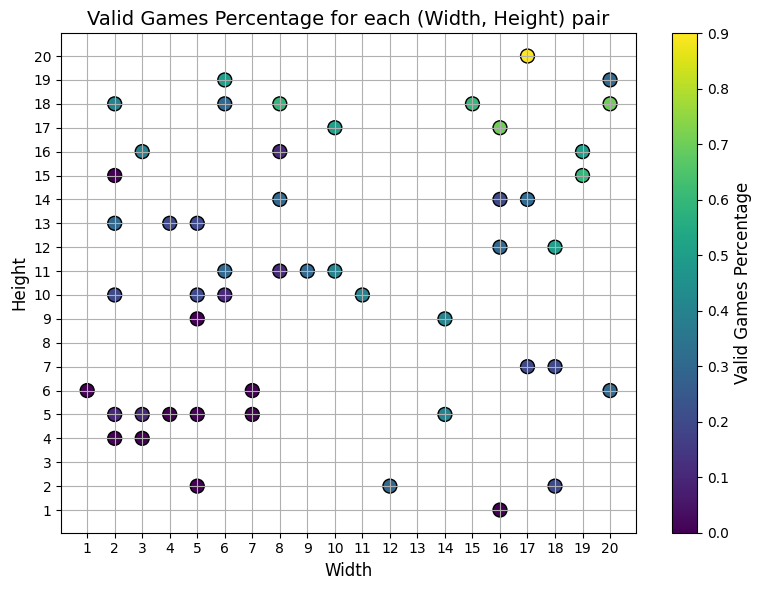

In [13]:
analyze_metric(results, lambda r: r.valid_games_percentage, 'Valid Games Percentage')

Mejores 5 de Unique Games Percentage:
Box(width=17, height=20) - 0.9
Box(width=16, height=17) - 0.7
Box(width=20, height=18) - 0.7
Box(width=8, height=18) - 0.6
Box(width=19, height=15) - 0.6
Peores 5 de Unique Games Percentage:
Box(width=5, height=5) - 0.0
Box(width=16, height=1) - 0.0
Box(width=7, height=6) - 0.0
Box(width=2, height=4) - 0.0
Box(width=3, height=4) - 0.0


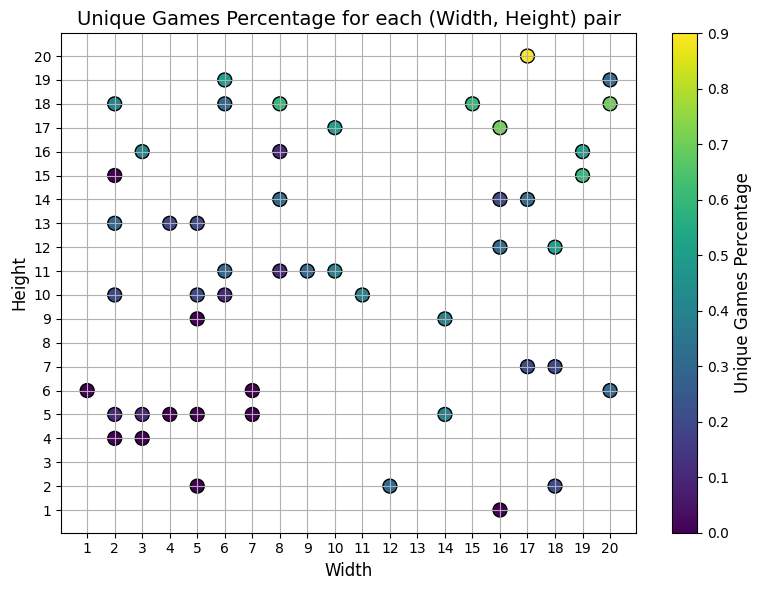

In [14]:
analyze_metric(results, lambda r: r.unique_games_percentage, 'Unique Games Percentage')

Mejores 5 de New Games Percentage:
Box(width=17, height=20) - 0.9
Box(width=16, height=17) - 0.7
Box(width=20, height=18) - 0.7
Box(width=8, height=18) - 0.6
Box(width=19, height=15) - 0.6
Peores 5 de New Games Percentage:
Box(width=5, height=5) - 0.0
Box(width=16, height=1) - 0.0
Box(width=7, height=6) - 0.0
Box(width=2, height=4) - 0.0
Box(width=3, height=4) - 0.0


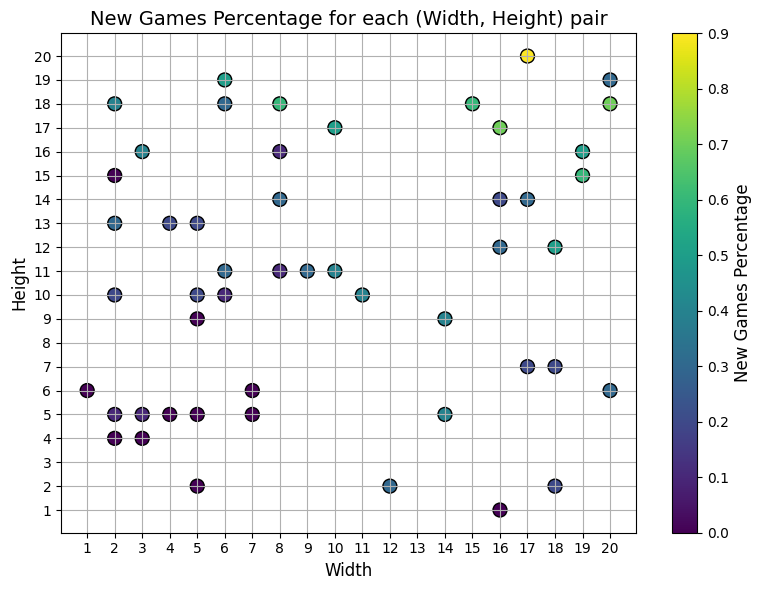

In [15]:
analyze_metric(results, lambda r: r.new_games_percentage, 'New Games Percentage')

Mejores 5 de Coverage Average:
Box(width=2, height=5) - 0.8
Box(width=16, height=14) - 0.5022321428571428
Box(width=10, height=11) - 0.4886363636363636
Box(width=17, height=14) - 0.4803921568627451
Box(width=16, height=12) - 0.4774305555555555
Peores 5 de Coverage Average:
Box(width=5, height=5) - 0
Box(width=16, height=1) - 0
Box(width=7, height=6) - 0
Box(width=2, height=4) - 0
Box(width=3, height=4) - 0


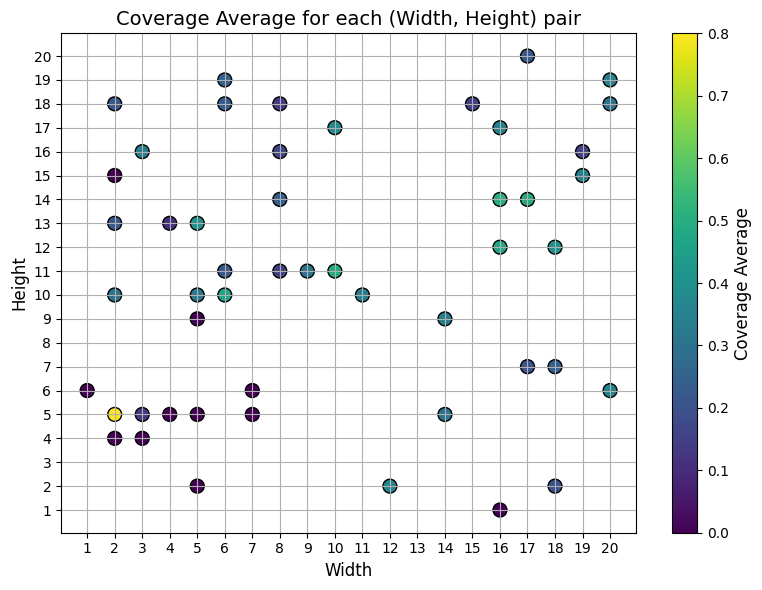

In [16]:
analyze_metric(results, lambda r: r.coverage_average, 'Coverage Average')

Mejores 5 de Box Count Average:
Box(width=16, height=14) - 4.0
Box(width=5, height=13) - 3.0
Box(width=17, height=14) - 2.6666666666666665
Box(width=11, height=10) - 2.5
Box(width=20, height=6) - 2.3333333333333335
Peores 5 de Box Count Average:
Box(width=5, height=5) - 0
Box(width=16, height=1) - 0
Box(width=7, height=6) - 0
Box(width=2, height=4) - 0
Box(width=3, height=4) - 0


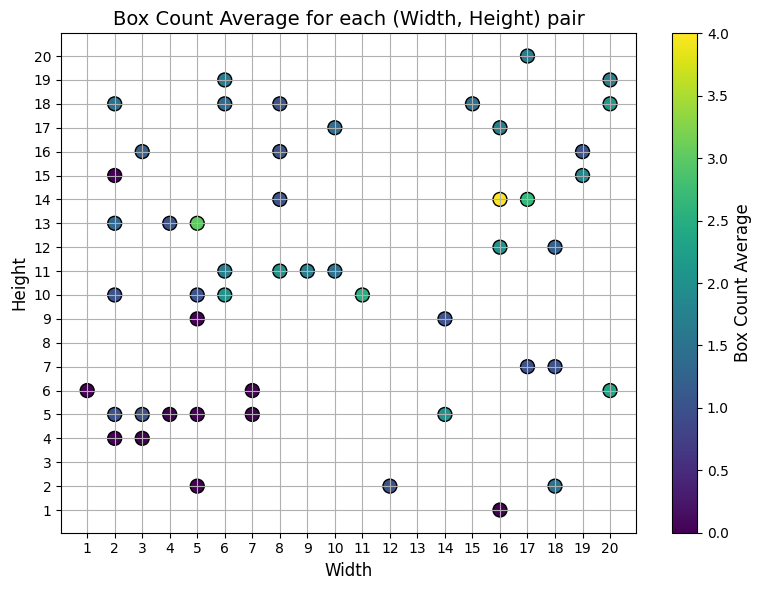

In [17]:
analyze_metric(results, lambda r: r.box_count_average, 'Box Count Average')

In [18]:
# Promedio total de todas las métricas en todas las configuraciones

valid_games_percentage =0
new_games_percentage = 0
unique_games_percentage = 0
coverage_average = 0
box_count_averags = 0

for result in results:
    valid_games_percentage += result.valid_games_percentage
    new_games_percentage += result.new_games_percentage
    unique_games_percentage += result.unique_games_percentage
    coverage_average += result.coverage_average
    box_count_averags += result.box_count_average

valid_games_percentage /= len(results)
new_games_percentage /= len(results)
unique_games_percentage /= len(results)
coverage_average /= len(results)
box_count_averags /= len(results)

print(f"Valid Games Percentage: {valid_games_percentage}")
print(f"New Games Percentage: {new_games_percentage}")
print(f"Unique Games Percentage: {unique_games_percentage}")
print(f"Coverage Average: {coverage_average}")
print(f"Box Count Average: {box_count_averags}")

Valid Games Percentage: 0.272
New Games Percentage: 0.272
Unique Games Percentage: 0.272
Coverage Average: 0.2391846135806726
Box Count Average: 1.2394761904761906


In [46]:
class AdvancedBingPackingProblemLoss(BaseBinPackingProblemLoss):
    def __init__(self, max_dim, device, dimension_loss_weight = 1, exceeding_area_penalty_weight = 1):
        super(AdvancedBingPackingProblemLoss, self).__init__(max_dim, device)
        self.dimension_loss_weight = dimension_loss_weight
        self.exceeding_area_penalty_weight = exceeding_area_penalty_weight
    
    def forward(self, container, logits_width, logits_height, target_seq):
        """
        Args:
            container: Tensor con las dimensiones del contenedor (batch_size, 2).
            logits_width: Logits de la distribución de width (batch_size, seq_len, max_dim+1).
            logits_height: Logits de la distribución de height (batch_size, seq_len, max_dim+1).
            target_seq: Secuencia objetivo (batch_size, seq_len, 2).
        
        Returns:
            Loss.
        """

        # Cross-entropy loss
        target_width = target_seq[:, :, 0].long()  # (batch_size, seq_len)
        target_height = target_seq[:, :, 1].long()  # (batch_size, seq_len)
        loss_width = self.axis_criterion(logits_width.view(-1, self.max_dim+1), target_width.view(-1))
        loss_height = self.axis_criterion(logits_height.view(-1, self.max_dim+1), target_height.view(-1))

        # Penalización si el área total de las cajas excede el área del contenedor
        container_area = container[:, 0] * container[:, 1]  # Área del contenedor (batch_size)
        total_area = target_width * target_height  # Área de cada caja (batch_size, seq_len)
        total_area = total_area.sum(dim=1)  # Área total sumada de todas las cajas (batch_size)

        # Penalización si el área total excede el área del contenedor
        excess_area = total_area - container_area
        excess_area = torch.clamp(excess_area, min=0)
        area_penalty_loss = (excess_area).mean() # Tomamos el promedio de los excesos penalizaciones

        return (loss_width + loss_height) * self.dimension_loss_weight + area_penalty_loss* self.exceeding_area_penalty_weight
        

In [68]:
# Datos de entrenamiento
criterion = AdvancedBingPackingProblemLoss(MAX_DIM, DEVICE, exceeding_area_penalty_weight=0.4)
input_dim = 2
hidden_dim = 10
n_layers = 2
dropout = 0

# Modelo
model = AutoRegressiveBinPackingModel(input_dim, hidden_dim, MAX_DIM, n_layers, dropout)
model.to(DEVICE)
# Hiperparámetros
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train(model,criterion, optimizer,epochs=2000)

Epoch 1/2000, Train Loss: 6.115124225616455
Epoch 1/2000, Val Loss: 6.098701000213623
Epoch 2/2000, Train Loss: 6.093863487243652
Epoch 2/2000, Val Loss: 6.0779314041137695
Epoch 3/2000, Train Loss: 6.075088977813721
Epoch 3/2000, Val Loss: 6.062450885772705
Epoch 4/2000, Train Loss: 6.055505990982056
Epoch 4/2000, Val Loss: 6.041457176208496
Epoch 5/2000, Train Loss: 6.034201622009277
Epoch 5/2000, Val Loss: 6.0235466957092285
Epoch 6/2000, Train Loss: 6.0189714431762695
Epoch 6/2000, Val Loss: 6.005134105682373
Epoch 7/2000, Train Loss: 5.997086763381958
Epoch 7/2000, Val Loss: 5.981091022491455
Epoch 8/2000, Train Loss: 5.980039596557617
Epoch 8/2000, Val Loss: 5.9606428146362305
Epoch 9/2000, Train Loss: 5.9588446617126465
Epoch 9/2000, Val Loss: 5.952329158782959
Epoch 10/2000, Train Loss: 5.944409608840942
Epoch 10/2000, Val Loss: 5.9266791343688965
Epoch 11/2000, Train Loss: 5.921072959899902
Epoch 11/2000, Val Loss: 5.906550407409668
Epoch 12/2000, Train Loss: 5.902605533599853

Mejores 5 de Valid Games Percentage:
Box(width=15, height=20) - 1.0
Box(width=20, height=17) - 1.0
Box(width=20, height=18) - 1.0
Box(width=16, height=20) - 1.0
Box(width=19, height=19) - 1.0
Peores 5 de Valid Games Percentage:
Box(width=6, height=1) - 0.0
Box(width=1, height=13) - 0.0
Box(width=1, height=8) - 0.0
Box(width=10, height=3) - 0.0
Box(width=1, height=14) - 0.0


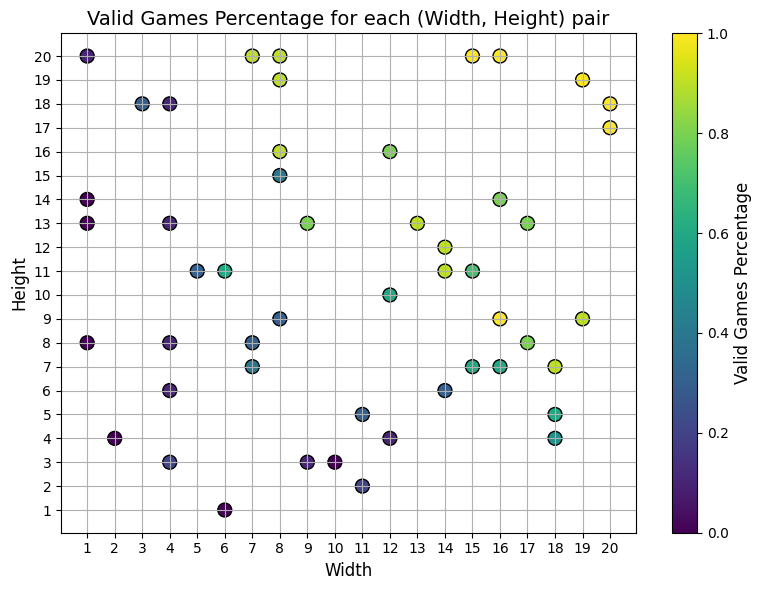

Mejores 5 de Unique Games Percentage:
Box(width=15, height=20) - 1.0
Box(width=20, height=17) - 1.0
Box(width=20, height=18) - 1.0
Box(width=16, height=20) - 1.0
Box(width=19, height=19) - 1.0
Peores 5 de Unique Games Percentage:
Box(width=6, height=1) - 0.0
Box(width=1, height=13) - 0.0
Box(width=1, height=8) - 0.0
Box(width=10, height=3) - 0.0
Box(width=1, height=14) - 0.0


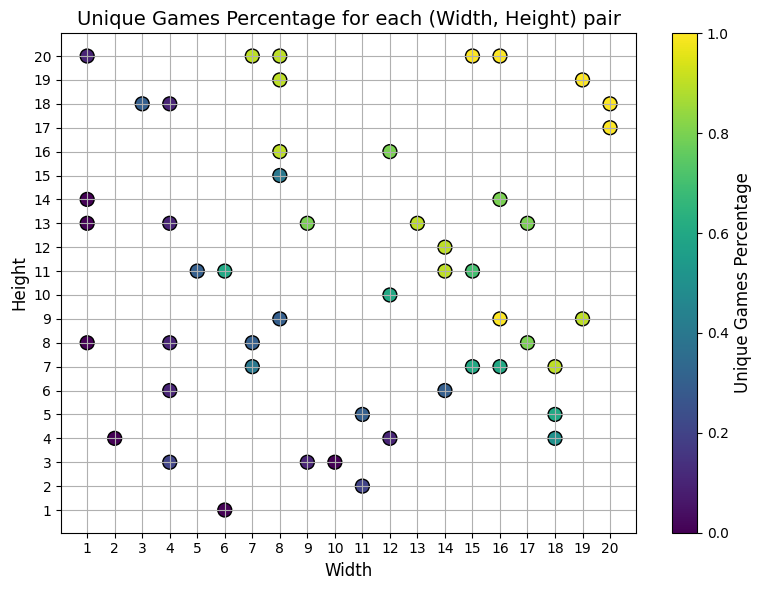

Mejores 5 de New Games Percentage:
Box(width=15, height=20) - 1.0
Box(width=20, height=17) - 1.0
Box(width=20, height=18) - 1.0
Box(width=16, height=20) - 1.0
Box(width=19, height=19) - 1.0
Peores 5 de New Games Percentage:
Box(width=6, height=1) - 0.0
Box(width=1, height=13) - 0.0
Box(width=1, height=8) - 0.0
Box(width=10, height=3) - 0.0
Box(width=1, height=14) - 0.0


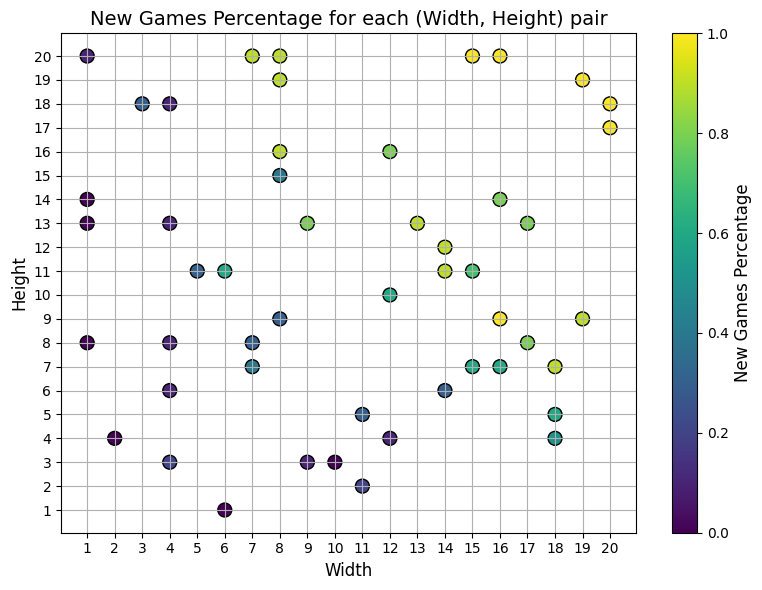

Mejores 5 de Coverage Average:
Box(width=12, height=4) - 1.0
Box(width=11, height=2) - 0.8863636363636364
Box(width=3, height=18) - 0.6728395061728395
Box(width=11, height=5) - 0.6424242424242425
Box(width=4, height=3) - 0.625
Peores 5 de Coverage Average:
Box(width=6, height=1) - 0
Box(width=1, height=13) - 0
Box(width=1, height=8) - 0
Box(width=10, height=3) - 0
Box(width=1, height=14) - 0


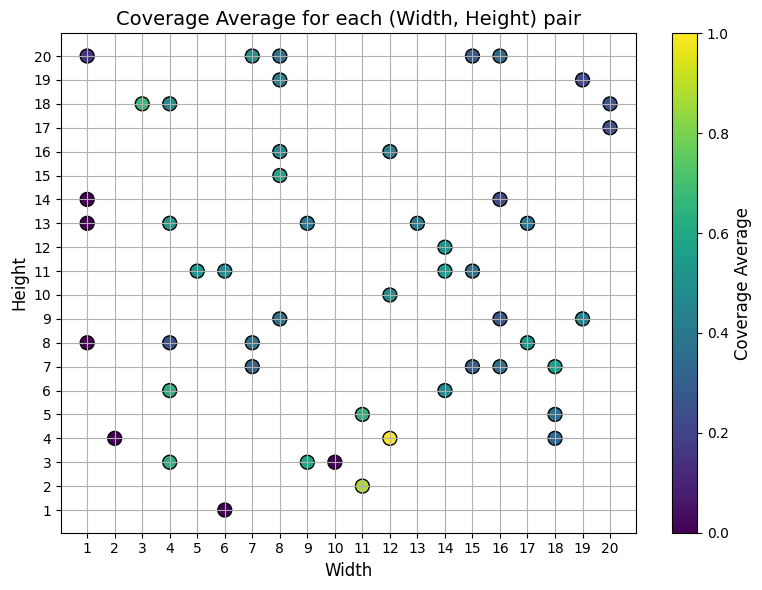

Mejores 5 de Box Count Average:
Box(width=17, height=13) - 5.25
Box(width=8, height=15) - 4.75
Box(width=12, height=16) - 4.625
Box(width=12, height=10) - 4.5
Box(width=13, height=13) - 4.444444444444445
Peores 5 de Box Count Average:
Box(width=6, height=1) - 0
Box(width=1, height=13) - 0
Box(width=1, height=8) - 0
Box(width=10, height=3) - 0
Box(width=1, height=14) - 0


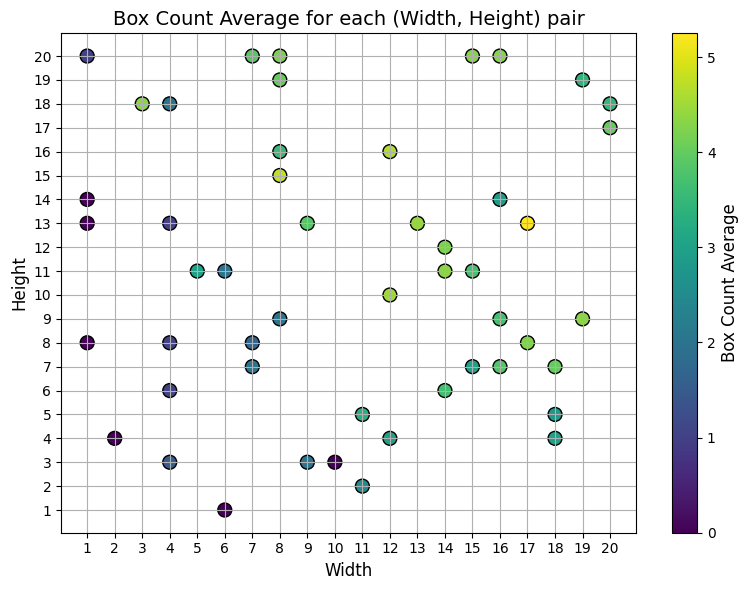

Valid Games Percentage: 0.5200000000000004
New Games Percentage: 0.5200000000000004
Unique Games Percentage: 0.5200000000000004
Coverage Average: 0.38961150393555305
Box Count Average: 2.8741190476190472


In [69]:
from evaluator import Evaluator

evaluator = Evaluator(
    sequence_generator= lambda container, sequence_lenght: generate_sequence(model, torch.tensor([[container.width, container.height]],dtype=torch.float32).to(DEVICE), sequence_lenght),
    dataset = full_dataset,
    max_sequence_length = 10,
    max_dim = MAX_DIM,
    configs_to_evaluate = 50,
    attempt_per_config = 10
)

results = evaluator.evaluate()
analyze_metric(results, lambda r: r.valid_games_percentage, 'Valid Games Percentage')
analyze_metric(results, lambda r: r.unique_games_percentage, 'Unique Games Percentage')
analyze_metric(results, lambda r: r.new_games_percentage, 'New Games Percentage')
analyze_metric(results, lambda r: r.coverage_average, 'Coverage Average')
analyze_metric(results, lambda r: r.box_count_average, 'Box Count Average')

# Promedio total de todas las métricas en todas las configuraciones
valid_games_percentage =0
new_games_percentage = 0
unique_games_percentage = 0
coverage_average = 0
box_count_averags = 0

for result in results:
    valid_games_percentage += result.valid_games_percentage
    new_games_percentage += result.new_games_percentage
    unique_games_percentage += result.unique_games_percentage
    coverage_average += result.coverage_average
    box_count_averags += result.box_count_average

valid_games_percentage /= len(results)
new_games_percentage /= len(results)
unique_games_percentage /= len(results)
coverage_average /= len(results)
box_count_averags /= len(results)

print(f"Valid Games Percentage: {valid_games_percentage}")
print(f"New Games Percentage: {new_games_percentage}")
print(f"Unique Games Percentage: {unique_games_percentage}")
print(f"Coverage Average: {coverage_average}")
print(f"Box Count Average: {box_count_averags}")

